lstm2

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: normalize+ denormalize

결과요약: seed 7: rmse 96.04 (마지막 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(77)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac3.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

In [5]:
sales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 1,
 1,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 282,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 230,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [6]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [7]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature + 가공

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

### X

계절

In [8]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

주중/주말(0,1)

In [9]:
day_of_week01s=[0,0,0,0,0,1,1]
day_of_week01= lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d" ).weekday())]

In [10]:
txs['season']=txs['date'].map(season)
txs['day_of_week01']=txs['date'].map(day_of_week01)
txs

,date,sales,year,month,week_number,day_of_week,season,day_of_week01
0,2016-01-01,34,2016,1,53,4,0,0
1,2016-01-02,41,2016,1,53,5,0,1
2,2016-01-03,54,2016,1,53,6,0,1
3,2016-01-04,41,2016,1,01,0,0,0
4,2016-01-05,35,2016,1,01,1,0,0
5,2016-01-06,44,2016,1,01,2,0,0
6,2016-01-07,50,2016,1,01,3,0,0
7,2016-01-08,42,2016,1,01,4,0,0
8,2016-01-09,42,2016,1,01,5,0,1
9,2016-01-10,66,2016,1,01,6,0,1


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음(아무런 가공되지 않은 원본 sales)

In [11]:
originalSales=list(txs['sales'])
sales=list(txs['sales'])

In [12]:
282 in originalSales

True

가공을 하는 순서도 중요한데, 이상점 제거-> log or sqrt -> normalization이다. 

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [13]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales

#### log(y)

In [14]:
def beforeLog(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return sales

In [15]:
def logSales(sales):
    return np.log(sales)

#### sqrt(y)

In [16]:
def sqrtSales(sales):
    return np.sqrt(sales)

In [17]:
# sales=noOutlierSales(sales)

In [18]:
sales=logSales(sales)

In [19]:
sales

array([ 3.52636052,  3.71357207,  3.98898405,  3.71357207,  3.55534806,
        3.78418963,  3.91202301,  3.73766962,  3.73766962,  4.18965474,
        3.91202301,  4.00733319,  4.02535169,  3.97029191,  3.78418963,
        3.98898405,  3.98898405,  3.91202301,  3.68887945,  3.8918203 ,
        3.33220451,  4.27666612,  4.26267988,  3.97029191,  3.76120012,
        3.63758616,  4.00733319,  3.8918203 ,  3.76120012,  3.8918203 ,
        3.8918203 ,  3.78418963,  3.66356165,  3.95124372,  3.80666249,
        3.49650756,  3.76120012,  3.68887945,  3.8286414 ,  3.8918203 ,
        3.91202301,  3.61091791,  3.61091791,  3.80666249,  3.87120101,
        3.87120101,  3.63758616,  4.09434456,  3.4339872 ,  3.55534806,
        3.97029191,  4.24849524,  4.12713439,  3.87120101,  3.93182563,
        3.8918203 ,  3.63758616,  3.4657359 ,  3.66356165,  3.55534806,
        3.40119738,  3.58351894,  3.4339872 ,  3.4339872 ,  3.78418963,
        3.71357207,  3.71357207,  3.80666249,  3.8286414 ,  3.80

In [20]:
282 in sales

False

In [21]:
282 in originalSales

True

### 1.3.2 x의 추가 가공

## 1.4 합친 후 (필요 시 normalize하여) 최종 data 생성: XY

계절(0~3) + 요일(0~6) + 주수(1~53) -> 판매량

In [22]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

계절(0~3) + 요일(0,1) + 주수(1~53) -> 판매량

In [23]:
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]

In [24]:
xy=np.array(tempxy).transpose().astype(np.float)
originalXY=np.array(tempxy).transpose().astype(np.float)

#### Normalization

In [25]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [26]:
xy=minMaxNormalizer(xy)

In [27]:
xy

array([[ 0.        ,  0.0754717 ,  1.        ,  0.0665351 ],
       [ 0.        ,  0.09433962,  1.        ,  0.0700674 ],
       [ 0.        ,  0.11320755,  1.        ,  0.07526385],
       ..., 
       [ 0.        ,  0.11320755,  0.0754717 ,  0.        ],
       [ 0.        ,  0.        ,  0.09433962,  0.03036675],
       [ 0.        ,  0.01886792,  0.09433962,  0.06479221]])

In [28]:
# xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [29]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [30]:
#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [31]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[ 0.          0.0754717   1.          0.0665351 ]
 [ 0.          0.09433962  1.          0.0700674 ]
 [ 0.          0.11320755  1.          0.07526385]
 [ 0.          0.          0.01886792  0.0700674 ]
 [ 0.          0.01886792  0.01886792  0.06708204]] -> [ 0.0713998]
[[ 0.          0.09433962  1.          0.0700674 ]
 [ 0.          0.11320755  1.          0.07526385]
 [ 0.          0.          0.01886792  0.0700674 ]
 [ 0.          0.01886792  0.01886792  0.06708204]
 [ 0.          0.03773585  0.01886792  0.0713998 ]] -> [ 0.07381175]
[[ 0.          0.11320755  1.          0.07526385]
 [ 0.          0.          0.01886792  0.0700674 ]
 [ 0.          0.01886792  0.01886792  0.06708204]
 [ 0.          0.03773585  0.01886792  0.0713998 ]
 [ 0.          0.05660377  0.01886792  0.07381175]] -> [ 0.07052207]
[[ 0.          0.          0.01886792  0.0700674 ]
 [ 0.          0.01886792  0.01886792  0.06708204]
 [ 0.          0.03773585  0.01886792  0.0713998 ]
 [ 0.          0.05660377  0.

## 2.4 train/test split

In [32]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [33]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [34]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

In [35]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.relu)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [36]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output과 fully connected layer를  이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [37]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [38]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [39]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [40]:
train = optimizer.minimize(loss)

# 3. Model 평가 with RMSE

In [41]:
denormalizedTestY=originalSales[train_size+seq_length:]
denormalizedTestY_preprocessed=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

In [42]:
121 in denormalizedTestY

True

In [43]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [44]:
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

## 2.5 Train and Test

[step: 0] loss: 1.6943939924240112
[step: 1] loss: 0.6791493892669678
[step: 2] loss: 0.2542327642440796
[step: 3] loss: 0.18853865563869476
[step: 4] loss: 0.31073468923568726
[step: 5] loss: 0.45160919427871704
[step: 6] loss: 0.4681846797466278
[step: 7] loss: 0.3806799352169037
[step: 8] loss: 0.2643451690673828
[step: 9] loss: 0.17020192742347717
[step: 10] loss: 0.11755038052797318
[step: 11] loss: 0.10391521453857422
[step: 12] loss: 0.11575105041265488
[step: 13] loss: 0.13574495911598206
[step: 14] loss: 0.1487766057252884
[step: 15] loss: 0.1458444595336914
[step: 16] loss: 0.1254304051399231
[step: 17] loss: 0.09359297156333923
[step: 18] loss: 0.06262640655040741
[step: 19] loss: 0.047619376331567764
[step: 20] loss: 0.058467525988817215
[step: 21] loss: 0.08498600870370865
[step: 22] loss: 0.09562084823846817
[step: 23] loss: 0.08335340768098831
[step: 24] loss: 0.06353362649679184
[step: 25] loss: 0.05020993947982788
[step: 26] loss: 0.04746761918067932
[step: 27] loss: 0

[step: 240] loss: 0.038579441606998444
[step: 241] loss: 0.03857046738266945
[step: 242] loss: 0.03856167197227478
[step: 243] loss: 0.03855301812291145
[step: 244] loss: 0.03854435309767723
[step: 245] loss: 0.03853568434715271
[step: 246] loss: 0.03852701559662819
[step: 247] loss: 0.038518309593200684
[step: 248] loss: 0.03850962221622467
[step: 249] loss: 0.03850090503692627
[step: 250] loss: 0.03849222511053085
[step: 251] loss: 0.0384836420416832
[step: 252] loss: 0.03847501426935196
[step: 253] loss: 0.038466379046440125
[step: 254] loss: 0.038457754999399185
[step: 255] loss: 0.03844911977648735
[step: 256] loss: 0.03844049200415611
[step: 257] loss: 0.03843184933066368
[step: 258] loss: 0.038423195481300354
[step: 259] loss: 0.038414549082517624
[step: 260] loss: 0.03840591385960579
[step: 261] loss: 0.038397252559661865
[step: 262] loss: 0.038388583809137344
[step: 263] loss: 0.038379911333322525
[step: 264] loss: 0.0383712463080883
[step: 265] loss: 0.03836259990930557
[step

[step: 489] loss: 0.03650248795747757
[step: 490] loss: 0.03649522736668587
[step: 491] loss: 0.03648802638053894
[step: 492] loss: 0.03648081049323082
[step: 493] loss: 0.03647361695766449
[step: 494] loss: 0.03646641969680786
[step: 495] loss: 0.036459095776081085
[step: 496] loss: 0.03645186498761177
[step: 497] loss: 0.03644465655088425
[step: 498] loss: 0.03643748536705971
[step: 499] loss: 0.03643031790852547
[step: 500] loss: 0.03642313927412033
[step: 501] loss: 0.03641596436500549
[step: 502] loss: 0.03640880808234215
[step: 503] loss: 0.036401666700839996
[step: 504] loss: 0.03639453276991844
[step: 505] loss: 0.036387406289577484
[step: 506] loss: 0.036380279809236526
[step: 507] loss: 0.036373160779476166
[step: 508] loss: 0.03636603057384491
[step: 509] loss: 0.03635890409350395
[step: 510] loss: 0.036351777613162994
[step: 511] loss: 0.03634466230869293
[step: 512] loss: 0.03633755445480347
[step: 513] loss: 0.03633049130439758
[step: 514] loss: 0.036323681473731995
[step

[step: 744] loss: 0.03497936949133873
[step: 745] loss: 0.0349707305431366
[step: 746] loss: 0.03496614471077919
[step: 747] loss: 0.03496016189455986
[step: 748] loss: 0.03495369479060173
[step: 749] loss: 0.03494898974895477
[step: 750] loss: 0.03494309261441231
[step: 751] loss: 0.03493649512529373
[step: 752] loss: 0.03493233770132065
[step: 753] loss: 0.03492511436343193
[step: 754] loss: 0.03492042422294617
[step: 755] loss: 0.03491368144750595
[step: 756] loss: 0.03491077199578285
[step: 757] loss: 0.034903187304735184
[step: 758] loss: 0.03490075841546059
[step: 759] loss: 0.034891702234745026
[step: 760] loss: 0.03488752245903015
[step: 761] loss: 0.03488044813275337
[step: 762] loss: 0.0348748043179512
[step: 763] loss: 0.03486988693475723
[step: 764] loss: 0.03486517444252968
[step: 765] loss: 0.034859444946050644
[step: 766] loss: 0.03485305979847908
[step: 767] loss: 0.034848202019929886
[step: 768] loss: 0.03484248369932175
[step: 769] loss: 0.03483639657497406
[step: 770

[step: 959] loss: 0.03374391421675682
[step: 960] loss: 0.033736180514097214
[step: 961] loss: 0.033731572329998016
[step: 962] loss: 0.03372511267662048
[step: 963] loss: 0.033719081431627274
[step: 964] loss: 0.03371487930417061
[step: 965] loss: 0.03370692580938339
[step: 966] loss: 0.03370264172554016
[step: 967] loss: 0.03369538486003876
[step: 968] loss: 0.03369078040122986
[step: 969] loss: 0.03368394449353218
[step: 970] loss: 0.033680036664009094
[step: 971] loss: 0.03367490693926811
[step: 972] loss: 0.03366677090525627
[step: 973] loss: 0.03366273641586304
[step: 974] loss: 0.03365504369139671
[step: 975] loss: 0.03365121781826019
[step: 976] loss: 0.03364378958940506
[step: 977] loss: 0.03363915532827377
[step: 978] loss: 0.03363293409347534
[step: 979] loss: 0.03362732380628586
[step: 980] loss: 0.03362173214554787
[step: 981] loss: 0.033614929765462875
[step: 982] loss: 0.03361090272665024
[step: 983] loss: 0.03360309824347496
[step: 984] loss: 0.03359881788492203
[step: 

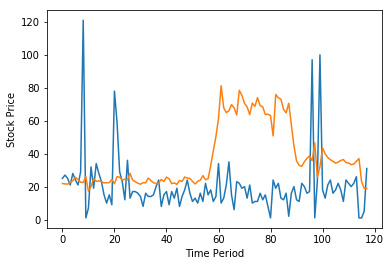

In [45]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = np.exp(minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY))
    rmse_val = sess.run(rmse, feed_dict={targets: denormalizedTestY_feed, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [46]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [47]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

32.357925497633069

In [48]:
rootMeanSquaredError(denormalizedTestY_preprocessed,denormalizedTestPredictY)

39.598740167051545

In [49]:
121 in denormalizedTestY

True

In [50]:
denormalizedTestY_preprocessed

array([ 3.21887582,  3.29583687,  3.21887582,  3.04452244,  3.33220451,
        3.17805383,  3.04452244,  3.36729583,  4.79579055,  0.        ,
        1.94591015,  3.4657359 ,  2.94443898,  3.52636052,  3.33220451,
        3.13549422,  2.7080502 ,  2.30258509,  2.7080502 ,  2.19722458,
        4.35670883,  4.07753744,  3.36729583,  3.13549422,  2.48490665,
        3.58351894,  2.56494936,  2.83321334,  2.83321334,  2.77258872,
        2.63905733,  2.07944154,  2.77258872,  2.63905733,  2.63905733,
        2.7080502 ,  2.99573227,  3.17805383,  2.07944154,  2.7080502 ,
        2.83321334,  2.19722458,  2.83321334,  2.56494936,  2.94443898,
        2.07944154,  2.63905733,  2.89037176,  3.17805383,  2.77258872,
        2.39789527,  2.56494936,  2.30258509,  2.77258872,  2.39789527,
        3.09104245,  2.7080502 ,  2.89037176,  2.39789527,  2.63905733,
        3.52636052,  2.30258509,  2.56494936,  3.04452244,  3.55534806,
        2.7080502 ,  1.79175947,  3.13549422,  3.09104245,  2.94